In [1]:
import time
import psycopg2
import datetime
from config import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

## Establishing connection to Database

In [36]:
conn = None

try:
    # read connection parameters
    params = config()

    # connect to the PostgreSQL server
    print('Connecting to the PostgreSQL database...')
    conn = psycopg2.connect(**params)

    # create a cursor
    cur = conn.cursor()
        
    # execute a statement, display the PostgreSQL database server version
    print('PostgreSQL database version:')
    cur.execute('SELECT version()')
    db_version = cur.fetchone()
    print(db_version)
       
    # execute a statement, fech pv ids
    
    cur.execute('SELECT date,time, yield FROM daily_yield WHERE yield IS NOT NULL')
    result = cur.fetchall()
    
    # close the communication with the PostgreSQL
    cur.close()
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
    
finally:
    if conn is not None:
        conn.close()
        print('Database connection closed.')

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.0 (Debian 13.0-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',)
Database connection closed.


In [37]:
print(result[0])

(datetime.date(2020, 7, 19), Decimal('174.00')) 12241


## Data Preparation
Converting SQL values to Dataframe, then convert the time column to datetime column and convert yield to numeric values

In [39]:
import pandas
df= pandas.DataFrame(result, columns=['date','time','yield'])
#print(df)

             date   yield
0      2020-07-19  174.00
1      2020-07-16   40.00
2      2020-07-16    7.00
3      2020-07-19  173.00
4      2020-07-19  163.00
...           ...     ...
51889  2019-12-27   25.00
51890  2019-12-27    0.00
51891  2019-12-27    0.00
51892  2019-12-27    0.00
51893  2019-12-27    0.00

[51894 rows x 2 columns]


In [7]:
#combining date and time column into one to convert it to datetime64 format
from datetime import datetime
df['date']=df.apply(lambda r : datetime.combine(r['date'],r['time']),1)
#print(df)

In [8]:
#Now, drop the time column and set the index to 'date'
df= df.drop(['time'], axis=1)


In [9]:
df= df.set_index('date')
#print(df)

In [10]:
#Values of yield is decimal, it's important to convert them to Numeric values to plot graphs etc
import pandas as pd
df["yield"] = pd.to_numeric(df["yield"])

In [11]:
print(df['yield'])

date
2020-07-21 15:15:00    1660.0
2020-07-21 15:20:00    3290.0
2020-07-21 15:25:00    4250.0
2020-07-21 15:30:00    4210.0
2020-07-21 15:35:00    4080.0
                        ...  
2020-07-16 17:45:00     737.0
2020-07-16 17:50:00     550.0
2020-07-16 17:55:00     497.0
2020-07-16 18:00:00     514.0
2020-07-16 18:05:00     541.0
Name: yield, Length: 33118051, dtype: float64


## Dataframe plotting and correlation plotting

<AxesSubplot:xlabel='date'>

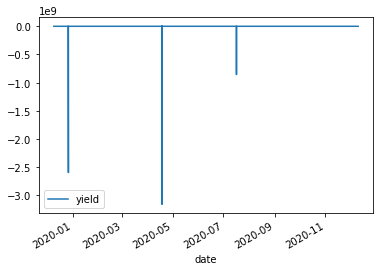

In [12]:
df.plot()

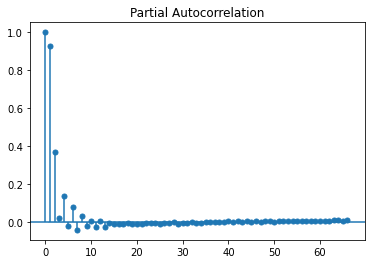

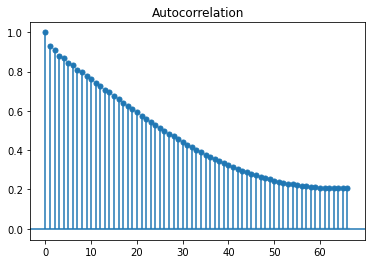

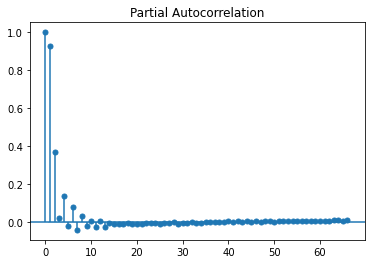

In [20]:
#Note: Due to large dataset,this took me 3-4 hours to run and plot correlation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df)
plot_pacf(df)

## MODEL BUILDING- SARIMAX
Refrence for pdarima- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
from statsmodels.tsa.arima_model import ARMA,ARIMA, ARMAResults, ARIMAResults

In [23]:
#using pmdarima to determine the best parameters (plag, order, qlag) 
#from pmdarima import auto_arima 
#auto_arima(df['yield'],seasonal=False).summary()

In [15]:
#taking the best parameters generated on subset of dataset consist of 1 Lacs rows as pmdarima do not work well on large datasets
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['yield'].values,order=(0,0,1))
model_fit= model.fit()
rmse = sqrt(mean_squared_error(df['yield'].values,model_fit.fittedvalues)) 
print('Test RMSE: %.3f' % rmse)

MemoryError: Unable to allocate 505. MiB for an array with shape (2, 1, 33118051) and data type float64

In [ ]:
#confirming if the above parameters work for entire dataset by taking different lag values and order
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['yield'].values,order=(12,1,12))
model_fit= model.fit()
rmse = sqrt(mean_squared_error(df['yield'].values,model_fit.fittedvalues)) 
print('Test RMSE: %.3f' % rmse)